# Random Forest Model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pymongo
import requests
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [3]:
results = client.census_DB.census.find()
cluster_data = []
for result in results:
    del result['_id']
    cluster_data.append(result)

In [4]:
cleaned_census_data = pd.DataFrame(cluster_data)
cleaned_census_data

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,MISSOURI,MO,LINN,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,MISSOURI,MO,HOWELL,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,MISSOURI,MO,JOHNSON,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,MISSOURI,MO,LACLEDE,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,MISSOURI,MO,MARIES,9140.0,43.1,44885.0,21883.0,14.070022,Republican
...,...,...,...,...,...,...,...,...,...,...
9002,2020,MINNESOTA,MN,RENVILLE,14572.0,44.0,58542.0,31243.0,9.422180,Republican
9003,2020,MINNESOTA,MN,ROSEAU,15259.0,41.6,62304.0,31452.0,7.425126,Republican
9004,2020,MINNESOTA,MN,SHERBURNE,96015.0,36.1,88671.0,36022.0,5.158569,Republican
9005,2020,MINNESOTA,MN,STEELE,36710.0,39.2,68172.0,34648.0,7.864342,Republican


In [5]:
#df = pd.read_csv('clean_data.csv')

In [6]:
cleaned_census_data.dtypes

year                   int64
state                 object
state_po              object
county_name           object
Population           float64
Median Age           float64
Household Income     float64
Per Capita Income    float64
Poverty Rate         float64
Winner                object
dtype: object

In [7]:
test_train_df = cleaned_census_data[(cleaned_census_data['year']==2012) | (cleaned_census_data['year']==2016 )]
test_train_df

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,MISSOURI,MO,LINN,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,MISSOURI,MO,HOWELL,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,MISSOURI,MO,JOHNSON,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,MISSOURI,MO,LACLEDE,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,MISSOURI,MO,MARIES,9140.0,43.1,44885.0,21883.0,14.070022,Republican
...,...,...,...,...,...,...,...,...,...,...
6001,2016,MICHIGAN,MI,WEXFORD,32829.0,41.9,40417.0,21200.0,18.520211,Republican
6002,2016,MICHIGAN,MI,CLINTON,77245.0,40.4,62646.0,31170.0,11.217555,Republican
6003,2016,MICHIGAN,MI,DICKINSON,25889.0,46.5,43373.0,25136.0,14.369037,Republican
6004,2016,MICHIGAN,MI,HURON,32021.0,48.3,43082.0,24455.0,13.737860,Republican


In [8]:
#drop non feature columns that are objects
test_train_df = test_train_df.drop(columns=['state', 'county_name','state_po'])

In [9]:
# Convert winner to 0 and 1
test_train_df['Winner']= test_train_df['Winner'].replace({'Democrat': 0, 'Republican': 1})
    

In [10]:
test_train_df

,year,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,12668.0,43.0,39028.0,20968.0,13.245974,1
1,2012,40330.0,39.6,34148.0,17763.0,20.300025,1
2,2012,52964.0,29.7,47960.0,21375.0,15.246205,1
3,2012,35507.0,39.1,39101.0,19788.0,18.244290,1
4,2012,9140.0,43.1,44885.0,21883.0,14.070022,1
...,...,...,...,...,...,...,...
6001,2016,32829.0,41.9,40417.0,21200.0,18.520211,1
6002,2016,77245.0,40.4,62646.0,31170.0,11.217555,1
6003,2016,25889.0,46.5,43373.0,25136.0,14.369037,1
6004,2016,32021.0,48.3,43082.0,24455.0,13.737860,1


In [11]:
test_train_df.dtypes

year                   int64
Population           float64
Median Age           float64
Household Income     float64
Per Capita Income    float64
Poverty Rate         float64
Winner                 int64
dtype: object

In [12]:
X = test_train_df.drop('Winner', axis=1)
y = test_train_df['Winner']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
clf = RandomForestClassifier(random_state=42, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.8552412645590682


Classification report:
              precision    recall  f1-score   support

           0       0.75      0.36      0.49       114
           1       0.87      0.97      0.92       487

    accuracy                           0.86       601
   macro avg       0.81      0.67      0.70       601
weighted avg       0.84      0.86      0.83       601

ROC AUC score: 0.665


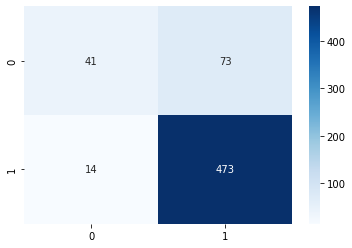

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Predict the labels for the test set
y_pred = clf.predict(X_test_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Compute and print the classification report
cr = classification_report(y_test, y_pred)
print("Classification report:")
print(cr)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC score: {roc_auc:.3f}")

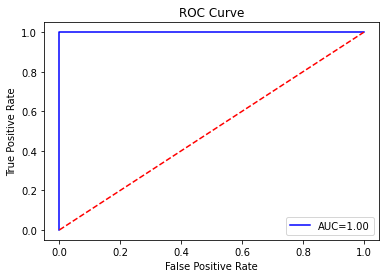

In [16]:
# Compute the predicted probabilities for the positive class
y_prob_train = clf.predict_proba(X_train_scaled)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds for the ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_prob_train)

# Compute the AUC for the ROC curve
auc_train = roc_auc_score(y_train, y_prob_train)

# Plot the ROC curve
plt.plot(fpr_train, tpr_train, color='blue', label=f'AUC={auc_train:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

ROC curve indicates overfitting, but based on ROC AUC score we believ the model is usable

[0.01799451 0.28371817 0.15477283 0.16541018 0.19171768 0.18638663]


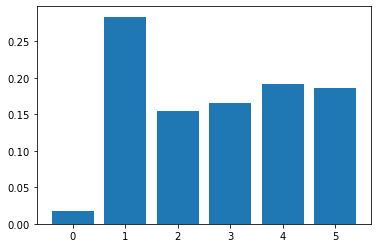

In [17]:
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

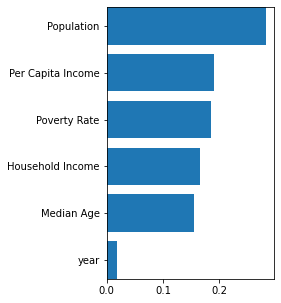

In [18]:
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(3,5)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

# SMOTE

In [19]:
# Separate the features and target variable
X = test_train_df.drop('Winner', axis=1)
y = test_train_df['Winner']

# Instantiate SMOTE
smote = SMOTE()

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print the class distribution before and after SMOTE
print('Class distribution before SMOTE:')
print(y.value_counts())

print('Class distribution after SMOTE:')
print(y_resampled.value_counts())

Class distribution before SMOTE:
1    4906
0    1100
Name: Winner, dtype: int64
Class distribution after SMOTE:
1    4906
0    4906
Name: Winner, dtype: int64


              precision    recall  f1-score   support

           0       0.85      0.69      0.76       487
           1       0.74      0.88      0.80       487

    accuracy                           0.78       974
   macro avg       0.80      0.78      0.78       974
weighted avg       0.80      0.78      0.78       974

ROC AUC score: 0.784


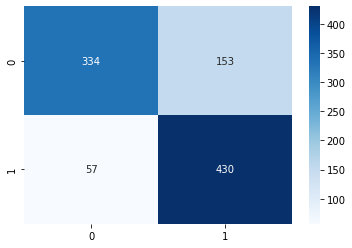

In [20]:
# Apply SMOTE to both training and test sets
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Train a Random Forest classifier on the resampled data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred = rf.predict(X_test_resampled)
print(classification_report(y_test_resampled, y_pred))

# Print the confusion matrix
cm = confusion_matrix(y_test_resampled, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test_resampled, y_pred)
print(f"ROC AUC score: {roc_auc:.3f}")

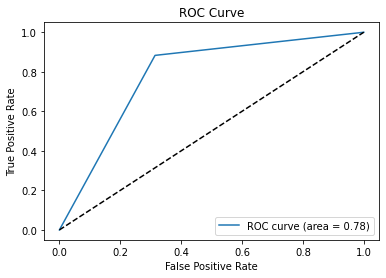

In [21]:
# Compute the ROC AUC score and plot the ROC curve
roc_auc = roc_auc_score(y_test_resampled, y_pred)
fpr, tpr, thresholds = roc_curve(y_test_resampled, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

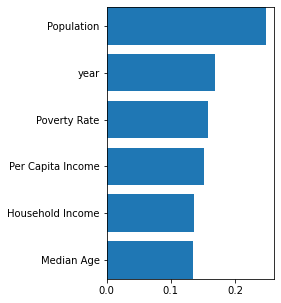

In [22]:
features = sorted(zip(X.columns, rf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(3,5)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

# Test Model

In [23]:
test_20 = cleaned_census_data[(cleaned_census_data['year']==2020)]

In [24]:
test_20

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
6006,2020,ALABAMA,AL,AUTAUGA,55639.0,38.6,57982.0,29804.0,15.086540,Republican
6007,2020,ALABAMA,AL,BALDWIN,218289.0,43.2,61756.0,33751.0,9.042599,Republican
6008,2020,ALABAMA,AL,BARBOUR,25026.0,40.1,34990.0,20074.0,25.221769,Republican
6009,2020,ALABAMA,AL,BIBB,22374.0,39.9,51721.0,22626.0,16.782873,Republican
6010,2020,ALABAMA,AL,BLOUNT,57755.0,41.0,48922.0,25457.0,13.586702,Republican
...,...,...,...,...,...,...,...,...,...,...
9002,2020,MINNESOTA,MN,RENVILLE,14572.0,44.0,58542.0,31243.0,9.422180,Republican
9003,2020,MINNESOTA,MN,ROSEAU,15259.0,41.6,62304.0,31452.0,7.425126,Republican
9004,2020,MINNESOTA,MN,SHERBURNE,96015.0,36.1,88671.0,36022.0,5.158569,Republican
9005,2020,MINNESOTA,MN,STEELE,36710.0,39.2,68172.0,34648.0,7.864342,Republican


In [25]:
#drop non feature columns that are objects
test_20 = test_20.drop(columns=['state', 'county_name','state_po'])

In [26]:
test_20

,year,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
6006,2020,55639.0,38.6,57982.0,29804.0,15.086540,Republican
6007,2020,218289.0,43.2,61756.0,33751.0,9.042599,Republican
6008,2020,25026.0,40.1,34990.0,20074.0,25.221769,Republican
6009,2020,22374.0,39.9,51721.0,22626.0,16.782873,Republican
6010,2020,57755.0,41.0,48922.0,25457.0,13.586702,Republican
...,...,...,...,...,...,...,...
9002,2020,14572.0,44.0,58542.0,31243.0,9.422180,Republican
9003,2020,15259.0,41.6,62304.0,31452.0,7.425126,Republican
9004,2020,96015.0,36.1,88671.0,36022.0,5.158569,Republican
9005,2020,36710.0,39.2,68172.0,34648.0,7.864342,Republican


In [27]:
#test_20.to_csv("2020clean_census.csv", encoding="utf-8", index=False)

In [28]:
# Convert winner to 0 and 1
test_20['Winner']= test_20['Winner'].replace({'Democrat': 0, 'Republican': 1})

In [29]:
X_new = test_20.drop('Winner', axis=1)
X_new_scaled = scaler.transform(X_new)

In [30]:
y_pred_new = clf.predict(X_new_scaled)

In [31]:
print(y_pred_new)

[1 1 1 ... 1 1 1]


              precision    recall  f1-score   support

           0       0.74      0.52      0.61       492
           1       0.91      0.96      0.94      2509

    accuracy                           0.89      3001
   macro avg       0.82      0.74      0.77      3001
weighted avg       0.88      0.89      0.88      3001

ROC AUC score for new data: 0.740


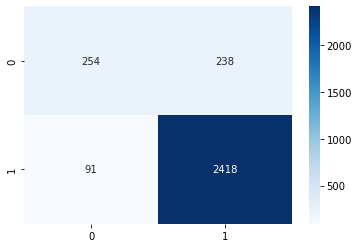

In [32]:
y_true_new = test_20['Winner']

# Make predictions on the new data
y_pred_new = clf.predict(X_new_scaled)

print(classification_report(y_true_new, y_pred_new))

roc_auc_new = roc_auc_score(y_true_new, y_pred_new)
print(f"ROC AUC score for new data: {roc_auc_new:.3f}")

# Compute the confusion matrix
cm = confusion_matrix(y_true_new, y_pred_new)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

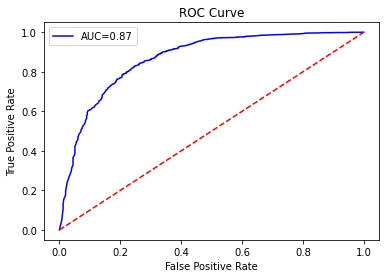

In [33]:
# Compute the predicted probabilities for the positive class
y_prob_new = clf.predict_proba(X_new_scaled)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_new, y_prob_new)

# Compute the AUC for the ROC curve
auc = roc_auc_score(y_true_new, y_prob_new)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label=f'AUC={auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Based on the results of the original data, the model had an accuracy of 0.86 with a precision of 0.87 for predicting winners, but had a low recall of 0.36 for predicting losers. The ROC AUC score was 0.665, which indicates the model had only slightly better performance than random guessing.

When applying SMOTE method, the recall significantly improved to .69 for predicting losers, but accuracy decreased to .78

When the model was tested on new data (2020 election results), it had an accuracy of 0.89 with a precision of 0.91 for predicting winners and a recall of 0.52 for predicting losers. The ROC AUC score was 0.74, which indicates the model had a moderate performance in predicting the winners.

